# Fundamental Matrix and RANSAC

In this exercise, you will learn:
- how to estimate the fundamental matrix $F$ that geometrically relates two views of the same scene
- how to make your estimation more robust to outliers and noise which is important in practice

For some functions we already provide some draft implementation that you just need to complete. This is supposed to help you identifying the next steps. Still, if it does not fit your idea you may ignore it.

## 1. Setup

Load all libraries and both views that we will work with. In this exercise you are given two views again and matching key points which we extracted in advance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal

In [2]:
from matplotlib.patches import ConnectionPatch

# use this function to visualize the matches
def plot_matches(img1, img2, keypoints1, keypoints2):
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    
    # draw matches
    for kp1, kp2 in zip(keypoints1, keypoints2):
        c = np.random.rand(3)
        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color=c)
        fig.add_artist(con)
        axes[0].plot(*kp1, color=c, marker='x')
        axes[1].plot(*kp2, color=c, marker='x')
    
    plt.show()

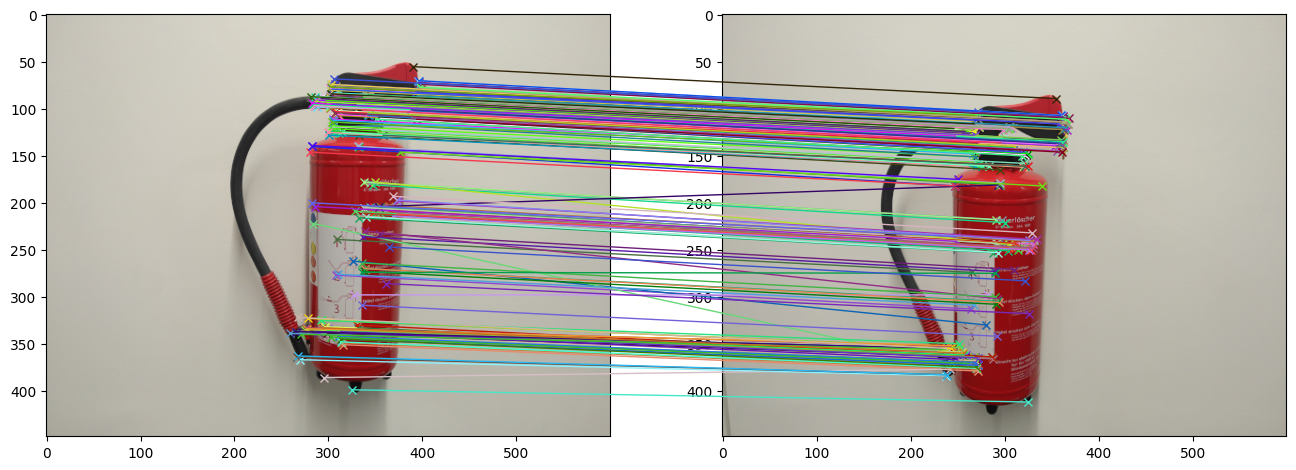

In [3]:
# Load images
view1 = np.array(Image.open("data/exercise3/view1.png")) / 255
view2 = np.array(Image.open("data/exercise3/view2.png")) / 255

# Load matching keypoints
with np.load("data/exercise4/keypoints.npz") as data:
    keypoints1 = data["view1"]
    keypoints2 = data["view2"]
    
plot_matches(view1, view2, keypoints1, keypoints2)

### 4.1. Fundamental Matrix
We begin with computing the fundamental matrix $F$ which defines the epipolar constraints for two views of two uncalibrated cameras. It determines the lines corresponding points can lie on. If we have a total of eight pairs of corresponding points this matrix can be estimated using the 8-point algorithm discussed in the lecture, see slide deck 

Your task now is to use eight point matches and compute the fundamental matrix $F$ by performing a direct linear transform and then decompose the resulting matrix using SVD. You might want to look at the slides again.

Hint: Use `numpy.linalg.svd` for singular value decomposition and do not forget to rescale the point coordinates to obtain stable results (this is termed 'conditioning' on the slides).

In [10]:
def condition_points(points):
    mean = np.mean(points[:, :2], axis=0)
    std_dev = np.std(points[:, :2])
    
    transform = np.array([
        [1 / std_dev, 0, -mean[0] / std_dev],
        [0, 1 / std_dev, -mean[1] / std_dev],
        [0, 0, 1]
    ])
    
    conditioned_points = (transform @ points.T).T
    return conditioned_points, transform

def construct_matrix_A(kps1, kps2):
    A = np.zeros((len(kps1), 9))
    for i in range(len(kps1)):
        x1, y1 = kps1[i][:2]
        x2, y2 = kps2[i][:2]
        A[i] = [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]
    return A

def solve_F_with_svd(A):
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
    
    U, S, Vt = np.linalg.svd(F)
    S[-1] = 0
    F_rank2 = U @ np.diag(S) @ Vt
    return F_rank2

def find_fundamental_svd(kps1, kps2):
    kps1_h = np.hstack((kps1, np.ones((kps1.shape[0], 1))))
    kps2_h = np.hstack((kps2, np.ones((kps2.shape[0], 1))))
    
    kps1_c, T1 = condition_points(kps1_h)
    kps2_c, T2 = condition_points(kps2_h)
    
    A = construct_matrix_A(kps1_c, kps2_c)
    
    F = solve_F_with_svd(A)
    
    F = T2.T @ F @ T1
    
    return F


In [11]:
# compute F from a set of 8 point matches
keypoints1 = np.array([[100, 150], [200, 250], [300, 350], [400, 450], [500, 550], [600, 650], [700, 750], [800, 850]])
keypoints2 = np.array([[110, 160], [210, 260], [310, 360], [410, 460], [510, 560], [610, 660], [710, 760], [810, 860]])

F = find_fundamental_svd(keypoints1, keypoints2)
print("Estimated Fundamental Matrix:\n", F)

Estimated Fundamental Matrix:
 [[ 3.30597193e-06  2.70907328e-06 -1.57258746e-03]
 [-9.92328518e-06  5.16253986e-06  3.43038158e-03]
 [ 1.14279697e-03 -3.75694254e-03 -8.82045360e-02]]


Check your code by visualizing the epipolar lines of you key points. We provide the function for this below. What do you see?

In [12]:
def visualize_epipolar_lines(img1, img2, keypoints1, keypoints2, F):
    """
    :params img1: view 1
    :params img2: view 2
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :params F: the fundamental matrix
    """
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    res = img1.shape[:2]
    
    for color_index, (kp1, kp2) in enumerate(zip(keypoints1, keypoints2)):
        c = np.random.rand(3)
        
        # plot points
        axes[0].plot(kp1[0], kp1[1], color=c, marker='o',markersize=5)
        axes[1].plot(kp2[0], kp2[1], color=c, marker='o',markersize=5)
        
        # compute epi lines
        epi_line_2 = kp1[None,...] @ F
        epi_line_1 = F @ kp2[None,...].T
        
        # plot lines
        for i, line in enumerate([epi_line_1, epi_line_2]):
            line = line.flatten()
            fn = lambda x: (line[0]*x + line[2]) / -line[1]
            xs = np.arange(res[1])
            axes[i].plot(xs, fn(xs), c=c)
    
    axes[0].set_ylim((res[0],0))
    axes[1].set_ylim((res[0],0))
    
    plt.show()

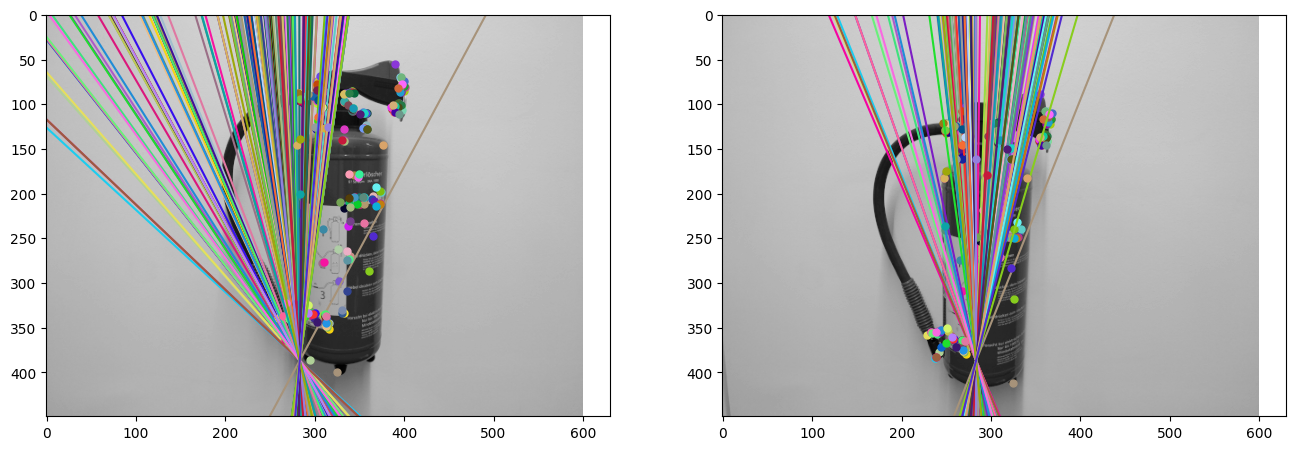

In [16]:
img1 = np.array(Image.open("data/exercise3/view1.png").convert('L'))
img2 = np.array(Image.open("data/exercise3/view2.png").convert('L'))

# Load matching keypoints
with np.load("data/exercise4/keypoints.npz") as data:
    keypoints1 = data["view1"]
    keypoints2 = data["view2"]

# Compute the fundamental matrix (using your function or example data)
F = find_fundamental_svd(keypoints1, keypoints2)

# Convert keypoints to homogeneous coordinates
keypoints1_h = np.hstack((keypoints1, np.ones((keypoints1.shape[0], 1))))
keypoints2_h = np.hstack((keypoints2, np.ones((keypoints2.shape[0], 1))))

visualize_epipolar_lines(img1, img2, keypoints1_h, keypoints2_h, F)

Also, compute the algebraic error, i.e. how well is the epipolar contraint $x_0^TFx_1=0$ met.
Furthermore, calculate the geometric error, i.e. are the points far away from the epipolar lines.
What do the algebraic and geometric error values show you?

In [19]:
def algebraic_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        error = np.abs(kp1[None,...] @ F @ kp2[None,...].T)
        errors.append(error.item())
    return errors

def geometric_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        x1F = kp1[None,...] @ F
        Fx2 = F @ kp2[None,...].T
        x1Fx2 = x1F @ kp2[None,...].T
        
        part1 = 1/(x1F.flatten()[0] ** 2 + x1F.flatten()[1] ** 2)
        part2 = 1/(Fx2.flatten()[0] ** 2 + Fx2.flatten()[1] ** 2)
        
        error = np.sqrt(x1Fx2 ** 2 * (part1 + part2))
        errors.append(error.item())
    return errors

def print_error_statistics(errors, error_type):
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    max_error = np.max(errors)
    min_error = np.min(errors)

    print(f"{error_type} Error Statistics:")
    print(f"Mean: {mean_error}")
    print(f"Standard Deviation: {std_error}")
    print(f"Maximum: {max_error}")
    print(f"Minimum: {min_error}")

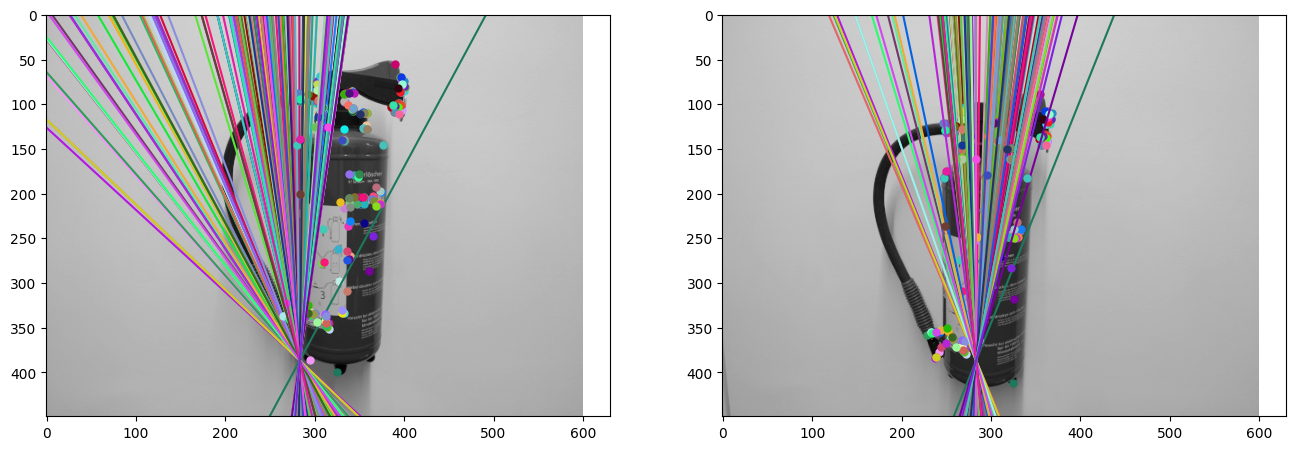

Algebraic Error Statistics:
Mean: 0.4743571924685619
Standard Deviation: 0.2131018532925733
Maximum: 0.817815430707971
Minimum: 0.013125488801841906
Geometric Error Statistics:
Mean: 94.85123272505439
Standard Deviation: 16.45498812520077
Maximum: 148.75363989105688
Minimum: 16.471929400891625


In [20]:
img1 = np.array(Image.open("data/exercise3/view1.png").convert('L'))
img2 = np.array(Image.open("data/exercise3/view2.png").convert('L'))

# Load matching keypoints
with np.load("data/exercise4/keypoints.npz") as data:
    keypoints1 = data["view1"]
    keypoints2 = data["view2"]

# Compute the fundamental matrix (using your function or example data)
F = find_fundamental_svd(keypoints1, keypoints2)

# Convert keypoints to homogeneous coordinates
keypoints1_h = np.hstack((keypoints1, np.ones((keypoints1.shape[0], 1))))
keypoints2_h = np.hstack((keypoints2, np.ones((keypoints2.shape[0], 1))))

visualize_epipolar_lines(img1, img2, keypoints1_h, keypoints2_h, F)

# Compute errors
alg_errors = algebraic_error(keypoints1_h, keypoints2_h, F)
geo_errors = geometric_error(keypoints1_h, keypoints2_h, F)

# Print error statistics
print_error_statistics(alg_errors, "Algebraic")
print_error_statistics(geo_errors, "Geometric")

### 4.2 Robust estimation using RANSAC
As some of the point matches suffer from noise or are even incorrect. The risk of obtaining an incorrect fundamental matrix by relying just on eight points is high. Hence, we are looking for a more robust version of estimating $F$. To do this, the RANSAC algorithm was introduced in the lecture. Your final task is to complete the implementation for fundamental matrix estimation by using RANSAC. You can compare the errors and epipolar lines of a robustly estimated $F$ with the one from the previous task.

In [27]:
def find_fundamental_svd(kps1, kps2):
    def condition_points(points):
        mean = np.mean(points[:, :2], axis=0)
        std_dev = np.std(points[:, :2])
        
        transform = np.array([
            [1 / std_dev, 0, -mean[0] / std_dev],
            [0, 1 / std_dev, -mean[1] / std_dev],
            [0, 0, 1]
        ])
        
        conditioned_points = (transform @ points.T).T
        return conditioned_points, transform

    def construct_matrix_A(kps1, kps2):
        A = np.zeros((len(kps1), 9))
        for i in range(len(kps1)):
            x1, y1 = kps1[i][:2]
            x2, y2 = kps2[i][:2]
            A[i] = [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]
        return A

    def solve_F_with_svd(A):
        U, S, Vt = np.linalg.svd(A)
        F = Vt[-1].reshape(3, 3)
        
        U, S, Vt = np.linalg.svd(F)
        S[-1] = 0
        F_rank2 = U @ np.diag(S) @ Vt
        return F_rank2

    kps1_c, T1 = condition_points(kps1)
    kps2_c, T2 = condition_points(kps2)
    
    A = construct_matrix_A(kps1_c, kps2_c)
    
    F = solve_F_with_svd(A)
    
    F = T2.T @ F @ T1
    
    return F


In [28]:
import numpy as np
import random
from PIL import Image

def find_fundamental_ransac(keypoints1, keypoints2, num_samples=8, threshold=0.01, iterations=1000, min_inliers=30):
    """
    Optimizes fundamental matrix parameters using RANSAC algorithm
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :param num_samples: the number of samples to draw in each iteration
    :param threshold: determines the error value at which we decide for inlier or outlier
    :iterations: maximum number of iterations
    :returns: fundamental matrix and a binary mask indicating the inlier points in keypoints1 and keypoints2
    
    """
    max_inliers = 0
    best_F = None
    best_inlier_mask = None

    for _ in range(iterations):
        sample_indices = random.sample(range(keypoints1.shape[0]), num_samples)
        kp1_sample = keypoints1[sample_indices]
        kp2_sample = keypoints2[sample_indices]
        
        F_candidate = find_fundamental_svd(kp1_sample, kp2_sample)
        
        inlier_mask = []
        for kp1, kp2 in zip(keypoints1, keypoints2):
            error = np.abs(kp1 @ F_candidate @ kp2.T)
            inlier_mask.append(error < threshold)
        
        inlier_mask = np.array(inlier_mask)
        num_inliers = np.sum(inlier_mask)
        
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_F = F_candidate
            best_inlier_mask = inlier_mask
        
        if num_inliers > min_inliers:
            break

    return best_F, best_inlier_mask

In [29]:
img1 = np.array(Image.open("data/exercise3/view1.png").convert('L'))
img2 = np.array(Image.open("data/exercise3/view2.png").convert('L'))

# Load matching keypoints
with np.load("data/exercise4/keypoints.npz") as data:
    keypoints1 = data["view1"]
    keypoints2 = data["view2"]

# Convert keypoints to homogeneous coordinates
keypoints1_h = np.hstack((keypoints1, np.ones((keypoints1.shape[0], 1))))
keypoints2_h = np.hstack((keypoints2, np.ones((keypoints2.shape[0], 1))))

# Compute the fundamental matrix using RANSAC
F_ransac, inliers = find_fundamental_ransac(keypoints1_h, keypoints2_h)

Now visualize again the epipolar lines and compute the errors. What has changed?

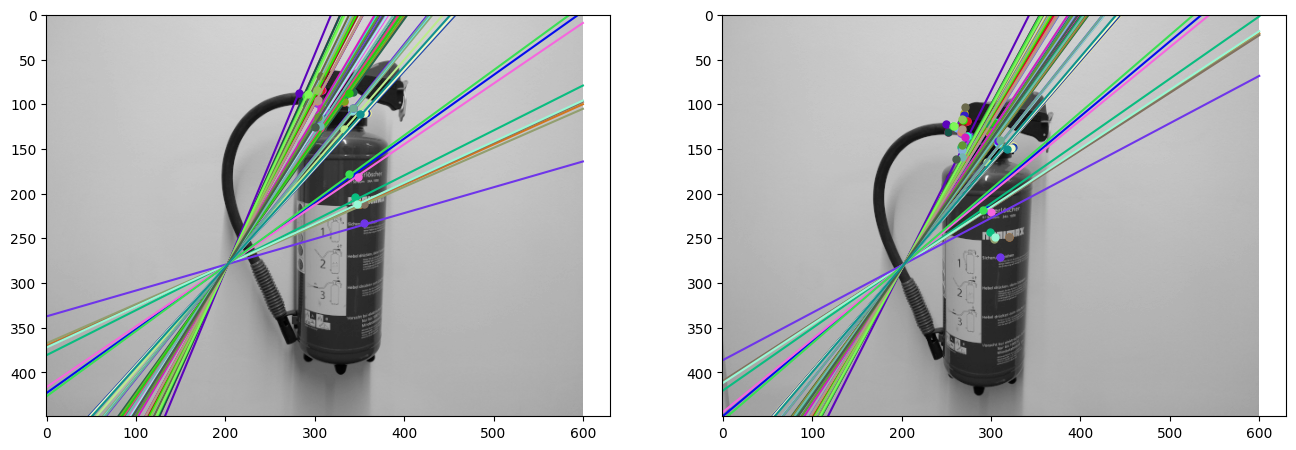

Algebraic (RANSAC) Error Statistics:
Mean: 0.004547981754148075
Standard Deviation: 0.002692256901906513
Maximum: 0.009959396073448978
Minimum: 7.292127339297849e-06
Geometric (RANSAC) Error Statistics:
Mean: 1.3742306295764573
Standard Deviation: 0.8398572037317766
Maximum: 3.9670449982905946
Minimum: 0.0019140813721966444


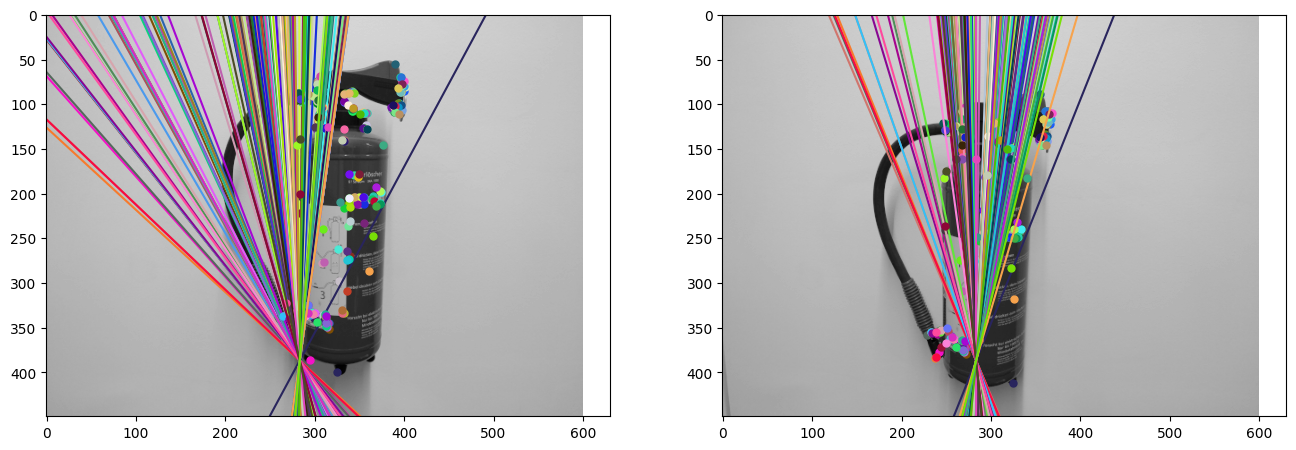

Algebraic (Original) Error Statistics:
Mean: 0.4743571924685619
Standard Deviation: 0.2131018532925733
Maximum: 0.817815430707971
Minimum: 0.013125488801841906
Geometric (Original) Error Statistics:
Mean: 94.85123272505439
Standard Deviation: 16.45498812520077
Maximum: 148.75363989105688
Minimum: 16.471929400891625


In [30]:
# Visualize epipolar lines for the RANSAC estimated fundamental matrix
visualize_epipolar_lines(img1, img2, keypoints1_h[inliers], keypoints2_h[inliers], F_ransac)

# Compute errors for the RANSAC estimated fundamental matrix
alg_errors_ransac = algebraic_error(keypoints1_h[inliers], keypoints2_h[inliers], F_ransac)
geo_errors_ransac = geometric_error(keypoints1_h[inliers], keypoints2_h[inliers], F_ransac)

# Print error statistics for the RANSAC estimated fundamental matrix
print_error_statistics(alg_errors_ransac, "Algebraic (RANSAC)")
print_error_statistics(geo_errors_ransac, "Geometric (RANSAC)")

# Visualize epipolar lines for the original fundamental matrix
F_original = find_fundamental_svd(keypoints1_h, keypoints2_h)
visualize_epipolar_lines(img1, img2, keypoints1_h, keypoints2_h, F_original)

# Compute errors for the original fundamental matrix
alg_errors_original = algebraic_error(keypoints1_h, keypoints2_h, F_original)
geo_errors_original = geometric_error(keypoints1_h, keypoints2_h, F_original)

# Print error statistics for the original fundamental matrix
print_error_statistics(alg_errors_original, "Algebraic (Original)")
print_error_statistics(geo_errors_original, "Geometric (Original)")